In [1]:
# Add the relevant scripts from LArMachineLearningData
# Nice the process so it can run with lots of cores on low priority
import os
os.nice(20)

# Add local paths
import sys
hnlDIR = os.environ['_']
sys.path.append('../pyscript')

# From pyscript Library
from Plotting import *
from Dictionary import *
from HelperFunctions import *
from CutFunctions import *

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import pyhf
from pyhf.contrib.viz import brazil

pyhf.set_backend("numpy")

In [2]:
ifSave = True
savePath = "../plot_files/07Mar2024_systematics/"

<h1> Read in HNL Dictionary </h1>

In [3]:
# Load
hnl_dict_m140 = np.load('./m140_v2.npy',allow_pickle='TRUE').item()
hnl_dict_m200 = np.load('./m200_v2.npy',allow_pickle='TRUE').item()
hnl_dict_m240 = np.load('./m240_v2.npy',allow_pickle='TRUE').item()

In [4]:
mass_list = [140, 200, 240]

In [5]:
hnl_dict = {**hnl_dict_m140, **hnl_dict_m200, **hnl_dict_m240}

del hnl_dict_m140
del hnl_dict_m200
del hnl_dict_m240

In [6]:
for k, v in hnl_dict[200].items():
    print(k ,v)
    print('\n')

U 8.944271909999159e-08


sig [34.000243328300584, 34.88429744154661, 33.95245661948658, 28.934852192961458, 24.08450124732053, 19.568657263447932, 15.387320241343673, 13.810358850150067, 11.636063598655852, 9.70070189128188]


sig_stat [5.830972760037606, 5.906293037222807, 5.826873657415835, 5.379112584150053, 4.907596279984788, 4.42364750669037, 3.922667490540547, 3.7162291170149975, 3.4111674832314893, 3.1145949802954926]


sig_flx_lo [31.800914975432615, 32.658440371597166, 31.893676088012022, 27.179128941359938, 22.813668829209742, 18.597344434802235, 14.578245061957615, 13.091650360276931, 11.025978368689604, 9.124556193495387]


sig_flx_hi [36.19776237311312, 37.23577074585134, 36.260294538984304, 30.978279455198773, 26.024894580689406, 21.289921639355597, 16.80683385374126, 15.102341306084043, 12.730542892312467, 10.546890333195986]


sig_flx_quadSum [3.109040873974278, 3.2378799231444226, 3.092683808514903, 2.694097086644968, 2.319513165106783, 1.9764108031632772, 1.633897653

<h1>Quadrature Sum Uncorr</h1>

In [7]:
model_dict = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": hnl_dict[200]['sig'],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_quadSum_sig", "type": "shapesys", "data": hnl_dict[200]['sig_quadSum']},
              ]
            },
            {
              "name": "background",
              "data": hnl_dict[200]['bkg'],
              "modifiers": [
                {"name": "uncorr_quadSum_bkg", "type": "shapesys", "data": hnl_dict[200]['bkg_quadSum']},
              ]
            }
          ]
        }
      ]
    }
    )

print(f'Samples:\n {model_dict.config.samples}')
print(f'Modifiers are:\n {model_dict.config.modifiers}')

# No DATA --> Data == Background

data = hnl_dict[200]['bkg'] + model_dict.config.auxdata

Samples:
 ['background', 'signal']
Modifiers are:
 [('mu', 'normfactor'), ('uncorr_quadSum_bkg', 'shapesys'), ('uncorr_quadSum_sig', 'shapesys')]


In [8]:
poi_values = np.linspace(0, 0.1, 50)

obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(data, 
                                                                                        model_dict, 
                                                                                        poi_values, 
                                                                                        level=0.1, 
                                                                                        return_results=True)

print(f"Upper limit (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

EXP_LIMIT = np.sqrt(exp_limits_single[2]) * hnl_dict[200]['U']
LIMIT = np.sqrt(obs_limit_single) * hnl_dict[200]['U']

print(f"Expected limit is " + str(EXP_LIMIT))
print(f"Observed limit is " + str(LIMIT)+ "\n")

quadSumUncorr = EXP_LIMIT

Upper limit (obs): μ = 0.0088
Upper limit (exp): μ = 0.0088

Expected limit is 8.382018243822478e-09
Observed limit is 8.382018243822478e-09



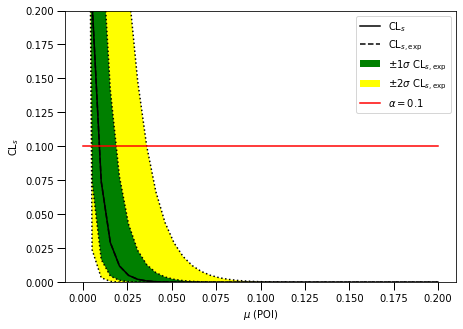

In [9]:
poi_vals = np.linspace(0, 0.2, 40)

results = [
    pyhf.infer.hypotest(
        test_poi, data, model_dict, test_stat="qtilde", return_expected_set=True
    )
    for test_poi in poi_vals
]

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
brazil.plot_results(poi_vals, results, ax=ax, test_size=0.10,)
plt.ylim(0.0,0.2)
fig.show()

<h1> Declare Flux/XSec/G4 As Correlated  </h1>

In [7]:
def declare_model(hnl_dict):
    model_dict = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": hnl_dict['sig'],
              "modifiers": [
                #fitting parameter
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                #stat - uncorrelated
                {"name": "stat_uncorr_sig" , "type": "shapesys", "data": hnl_dict['sig_stat']},
                #flux - correlated
                {"name": "flux_corr_sig" , "type": "histosys", "data": {"lo_data": hnl_dict['sig_flx_lo'], "hi_data": hnl_dict['sig_flx_hi']}},
                  
              ]
            },
            {
              "name": "background",
              "data": hnl_dict['bkg'],
              "modifiers": [
                #stat - uncorrelated
                {"name": "stat_uncorr_bkg" , "type": "shapesys", "data": hnl_dict['bkg_stat']},
                #flux - correlated
                {"name": "flux_corr_bkg" , "type": "histosys", "data": {"lo_data": hnl_dict['bkg_flx_lo'], "hi_data": hnl_dict['bkg_flx_hi']}},
                #xsec - correlated
                {"name": "xsec_corr_bkg" , "type": "histosys", "data": {"lo_data": hnl_dict['bkg_xsec_lo'], "hi_data": hnl_dict['bkg_xsec_hi']}},
                #g4 - correlated
                {"name": "g4_corr_bkg" , "type": "histosys", "data": {"lo_data": hnl_dict['bkg_g4_lo'], "hi_data": hnl_dict['bkg_g4_hi']}},
              ]
            }
          ]
        }
      ]
    }
    )

    print(f'Samples:\n {model_dict.config.samples}')
    print(f'Modifiers are:\n {model_dict.config.modifiers}')

    # No DATA --> Data == Background

    data = hnl_dict['bkg'] + model_dict.config.auxdata
    
    return model_dict, data

In [9]:
for m in mass_list:
    
    print('Fitting mass ' + str(m))
    model_dict, data = declare_model(hnl_dict[m])

    poi_values = np.linspace(0, 0.1, 50)

    obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(data, 
                                                                                        model_dict, 
                                                                                        poi_values, 
                                                                                        level=0.1, 
                                                                                        return_results=True)
    print()
    print(f"Upper limit (obs): μ = {obs_limit_single:.4f}")
    print(f"Upper limit (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

    EXP_LIMIT = np.sqrt(exp_limits_single[2]) * hnl_dict[m]['U']
    LIMIT = np.sqrt(obs_limit_single) * hnl_dict[m]['U']

    print(f"Expected limit is " + str(EXP_LIMIT))
    print(f"Observed limit is " + str(LIMIT)+ "\n")
    
    CL_bands = []
    for sigma in exp_limits_single:
        CL_bands.append(np.sqrt(sigma) * hnl_dict[m]['U'])
    
    hnl_dict[m]['Limits'] = CL_bands
    print(CL_bands)

Fitting mass 140
Samples:
 ['background', 'signal']
Modifiers are:
 [('flux_corr_bkg', 'histosys'), ('flux_corr_sig', 'histosys'), ('g4_corr_bkg', 'histosys'), ('mu', 'normfactor'), ('stat_uncorr_bkg', 'shapesys'), ('stat_uncorr_sig', 'shapesys'), ('xsec_corr_bkg', 'histosys')]

Upper limit (obs): μ = 0.0079
Upper limit (exp): μ = 0.0079

Expected limit is 1.7116392836494651e-07
Observed limit is 1.7116392836494651e-07

[8.684992781942812e-08, 1.203586452661153e-07, 1.7116392836494651e-07, 2.4758624579254633e-07, 3.450416970163241e-07]
Fitting mass 200
Samples:
 ['background', 'signal']
Modifiers are:
 [('flux_corr_bkg', 'histosys'), ('flux_corr_sig', 'histosys'), ('g4_corr_bkg', 'histosys'), ('mu', 'normfactor'), ('stat_uncorr_bkg', 'shapesys'), ('stat_uncorr_sig', 'shapesys'), ('xsec_corr_bkg', 'histosys')]

Upper limit (obs): μ = 0.0088
Upper limit (exp): μ = 0.0088

Expected limit is 8.371627933396566e-09
Observed limit is 8.371627933396566e-09

[4.364052642159876e-09, 5.8387771409

In [41]:
for m in mass_list:
    print(hnl_dict[m]['U'])

1.9235384061671345e-06
8.944271909999159e-08
4.147288270665544e-08


<h1>Plot</h1>

In [14]:
neg2sigma = []
neg1sigma = []
expect = []
pos1sigma = []
pos2sigma = []

for m in mass_list:
    neg2sigma.append(hnl_dict[m]['Limits'][0])
    neg1sigma.append(hnl_dict[m]['Limits'][1])
    expect.append(hnl_dict[m]['Limits'][2])
    pos1sigma.append(hnl_dict[m]['Limits'][3])
    pos2sigma.append(hnl_dict[m]['Limits'][4])
    

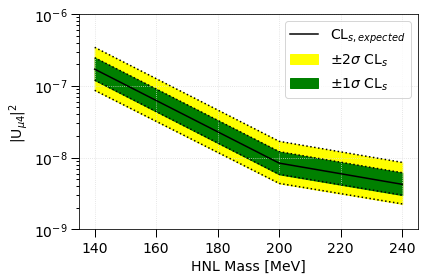

In [46]:
fig, ax1 = plt.subplots(1,1, figsize=(6,4))

xlimmin = 140
xlimmax = 240

plt.grid(axis = 'both', color='gainsboro', linestyle = ":")
#-------------------------------------------------------------------
ax1.plot(mass_list, neg2sigma, color = 'black', linestyle = ':')
ax1.plot(mass_list, neg1sigma, color = 'black', linestyle = ':')
ax1.plot(mass_list, pos1sigma, color = 'black', linestyle = ':')
ax1.plot(mass_list, pos2sigma, color = 'black', linestyle = ':')


ax1.plot(mass_list, expect, color = 'black', linestyle = '-', label = r'CL$_{s, expected}$')
#-------------------------------------------------------------------

 
ax1.fill_between(mass_list, neg2sigma, pos2sigma, color = 'yellow', label = r'$\pm 2 \sigma$ CL$_{s}$')
ax1.fill_between(mass_list, neg1sigma, pos1sigma, color = 'green', label = r'$\pm 1 \sigma$ CL$_{s}$')   

#-------------------------------------------------------------------
#plt.xlim(180, 220)
plt.ylim(1e-9, 1e-6)
ax1.set_yscale('log')

plt.legend(loc="upper right", fontsize =14)

ax1.set_xlabel( "HNL Mass [MeV]", fontsize =14)
ax1.set_ylabel("|U$_{\mu4}$|$^2$", fontsize =14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#-------------------------------------------------------------------
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("sensitivity_test.png"), dpi=200)
plt.show()